In [1]:
import pandas as pd
import numpy as np
import nltk
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn import naive_bayes
from sklearn.metrics import roc_auc_score,accuracy_score
import pickle
import seaborn as sns
import matplotlib.pyplot as plt
import missingno as msno
from sklearn.preprocessing import StandardScaler, MinMaxScaler, binarize
from sklearn.model_selection import train_test_split, cross_val_score, KFold, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier, ExtraTreesClassifier
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score, roc_curve, accuracy_score
from sklearn.feature_selection import SelectKBest, chi2

In [2]:
nltk.download("stopwords")

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\harsh\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [3]:
dataset = pd.read_csv('datasets/reviews.txt',sep = '\t', names =['Reviews','Comments'])

In [4]:
dataset

,Reviews,Comments
0,1,The Da Vinci Code book is just awesome.
1,1,this was the first clive cussler i've ever rea...
2,1,i liked the Da Vinci Code a lot.
3,1,i liked the Da Vinci Code a lot.
4,1,I liked the Da Vinci Code but it ultimatly did...
...,...,...
6913,0,Brokeback Mountain was boring.
6914,0,So Brokeback Mountain was really depressing.
6915,0,"As I sit here, watching the MTV Movie Awards, ..."
6916,0,Ok brokeback mountain is such a horrible movie.


In [5]:
stopset = set(stopwords.words('english'))

In [6]:
vectorizer = TfidfVectorizer(use_idf = True,lowercase = True, strip_accents='ascii',stop_words=stopset)

In [7]:
X = vectorizer.fit_transform(dataset.Comments)
y = dataset.Reviews
pickle.dump(vectorizer, open('tranform.pkl', 'wb'))

In [8]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

In [9]:
y_test

543     1
1820    1
2412    1
3409    1
5741    0
       ..
2436    1
1509    1
5153    0
2883    1
2470    1
Name: Reviews, Length: 1384, dtype: int64

In [10]:
models = []
models.append(('LR', LogisticRegression()))
models.append(('LDA', LinearDiscriminantAnalysis()))
models.append(('CART', DecisionTreeClassifier()))
models.append(('KNN', KNeighborsClassifier()))
models.append(('SVM', SVC()))
models.append(('RF', RandomForestClassifier()))
models.append(('ADA', AdaBoostClassifier()))
models.append(('GB', GradientBoostingClassifier()))

In [11]:
 # Creating a function to decide which of the classification method is the best
def model_selection(X_train, y_train):
    acc_result = []
    auc_result = []
    names = []

    col = ['Model', 'ROC AUC Mean','ROC AUC Std','ACC Mean', 'ACC Std']
    result = pd.DataFrame(columns = col)

    i=0
    for name, model in models:
        kfold = KFold(n_splits = 10, random_state = 7)
        cv_acc_result  = cross_val_score(model, X_train, y_train, cv = kfold, scoring = 'accuracy')
        cv_auc_result  = cross_val_score(model, X_train, y_train, cv = kfold, scoring = 'roc_auc')

        acc_result.append(cv_acc_result)
        auc_result.append(cv_auc_result)
        names.append(name)

        result.loc[i] = [name, 
                         cv_auc_result.mean(), 
                         cv_auc_result.std(),
                         cv_acc_result.mean(),
                         cv_acc_result.std()]

        result = result.sort_values('ROC AUC Mean', ascending = False)
        i+= 1

    plt.figure(figsize = (10,5))
    plt.subplot(1,2,1)
    sns.boxplot(x = names, y = auc_result)
    plt.title('ROC AUC Score')

    plt.subplot(1,2,2)
    sns.boxplot(x = names, y = acc_result)
    plt.title('Accuracy Score')
    plt.show()

    return(result)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: A sparse matrix was passed, but dense data is required. Use X.toarray() to convert to a dense numpy array.

  FitFailedWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:296

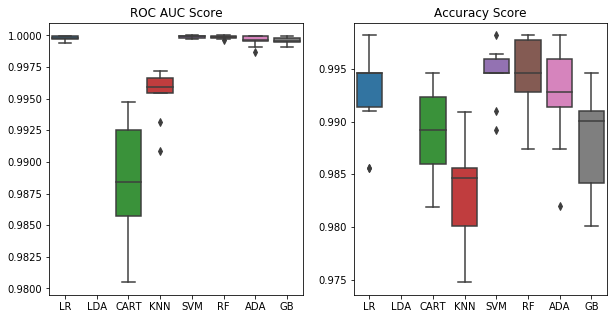

,Model,ROC AUC Mean,ROC AUC Std,ACC Mean,ACC Std
4,SVM,0.999900,0.000100,0.994399,0.002480
5,RF,0.999848,0.000104,0.994400,0.003467
0,LR,0.999766,0.000186,0.992775,0.004034
6,ADA,0.999588,0.000398,0.992414,0.004550
7,GB,0.999574,0.000237,0.988254,0.004448
3,KNN,0.995378,0.001864,0.983377,0.004762
2,CART,0.988749,0.004329,0.988978,0.003742
1,LDA,NaN,NaN,NaN,NaN


In [12]:
model_selection(X_train, y_train)

In [13]:
clf = AdaBoostClassifier()
clf.fit(X,y)

AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None, learning_rate=1.0,
                   n_estimators=50, random_state=None)

In [14]:
accuracy_score(y_test,clf.predict(X_test))*100

99.4942196531792

In [15]:
filename = 'nlp_model.pkl'
pickle.dump(clf, open(filename, 'wb'))